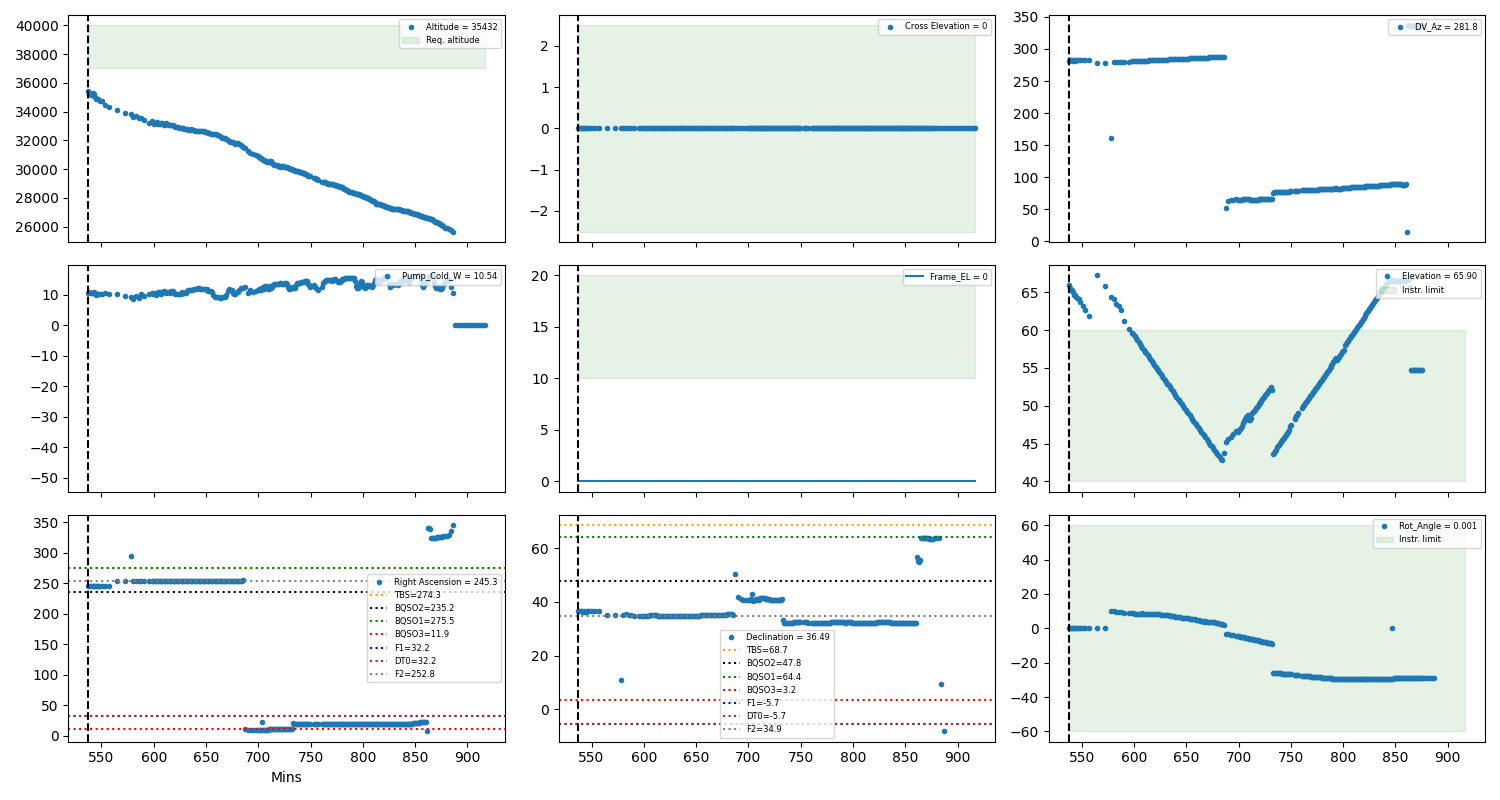

In [60]:

%matplotlib widget
from mpl_toolkits.basemap import Basemap

import matplotlib.pyplot as plt
from astropy.table import Table
from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
import ipywidgets as widgets
import numpy as np
from scipy import interpolate
from datetime import datetime, timedelta


from astropy.utils.data import download_file
from astropy.utils import iers
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.coordinates import get_sun

iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, cache=True))

def calc(obj, loc, time):

        rad = np.pi/180.

        # - altitutde and azimuth -#
        altaz = obj.transform_to(AltAz(obstime=time, location = loc))
        alt = np.array((altaz.alt)*u.deg)
        az = np.array((altaz.az)*u.deg)

        # rotation speed
        rot_speed = (15.0417827*np.cos(loc.lat.deg*rad)*np.cos(az*rad))/np.cos(alt*rad)

        # - return label array -
        label = np.array(obj.dec*u.deg)
        #print np.array(altaz.obstime)
        return alt, az, rot_speed, label



def add_line(cat, y, ax, x, i=0, init=True,l=None,style='-',display=True, change=False, ylabel=None,log=False,ylim=None, **kwargs):
    if ylabel is None:
        ylabel = y
    if display == False:
        label = None
    else:
        try:
            label = ylabel.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
        except KeyError as e:
            label = None#ylabel
    # print(label)
    if init:
        if log:
            if display==False: 
                l = ax.semilogy(cat.eval(x),cat.eval(y),ls='none', **kwargs)
            else:
                l = ax.semilogy(cat.eval(x),cat.eval(y),ls=style, **kwargs)
        else:
            if display==False: 
                l = ax.plot(cat.eval(x),cat.eval(y),ls='none', **kwargs)
            else:
                l = ax.plot(cat.eval(x),cat.eval(y),style, **kwargs)
        if ylim is not None:
            ax.set_ylim(ylim)
        # ax.set_ylabel(ylabel)      
    if change:
        l[0].set_data(cat.eval(x),cat.eval(y))
        if display==False:
            l[0].set_linestyle('none')
        else:
            l[0].set_linestyle(style)
    l[0].set_label(label)
    if label is not None:
        ax.legend(loc="upper right", fontsize=6)
    return l


style={}#{'description_width': 'initial'} 
width = '400px'
continuous_update=True


TBS = ["TBS",274.3341, 68.6707, 220]
BQSO2 = ["BQSO2",235.22, 47.75, -140]
BQSO1 = ["BQSO1",275.48, 64.36, -70]
BQSO3 = ["BQSO3",11.87, 3.24, 0]
F1 = ["F1",32.19, -5.688, 0]
DT0 = ["DT0",32.19, -5.688, 0]
F2 = ["F2",252.85, 34.92, -70]
fields = [TBS , BQSO2, BQSO1, BQSO3, F1  , DT0, F2]

class dashboard_CNES(widgets.HBox):
     
    def __init__(self,x=None,cat=None,style="."):
        super().__init__()
        self.output = widgets.Output()
        self.x = x
        # self.ax1bis = self.ax1.twinx()

        self.fig, self.axes = plt.subplots(3,3, figsize=(15,8),sharex=True)
        # for axs in self.axes[:-1]:
        #     for ax in axs:
        #         ax.xaxis.set_ticklabels([])
        # # for ax in self.axes.flatten()[2:]:
        #     ax.sharex(self.axes.flatten()[1])
        self.cat=cat
        # (self.a0,self.a1,self.a2,self.a3) = self.axes
        a0, a1, a2 = self.axes
        a2[0].set_xlabel(x)



        size = 10
        # m = Basemap(projection='lcc', width=6*900000,height=3*900000,lat_0=cat["Latitude"].mean()-size, lat_1=cat["Latitude"].mean()+size/2,lon_0=cat["Longi"].mean()-size/2, lon_1=cat["Longi"].mean()+size, resolution='i', area_thresh=1000.,ax=a0[0])

        if 1==0:
            m = Basemap(projection='cyl',llcrnrlat=cat["Latitude"].mean()-size/10, urcrnrlat=cat["Latitude"].mean()+size/10,llcrnrlon=cat["Longi"].mean()-size/4, urcrnrlon=cat["Longi"].mean()+size/4, resolution='f', area_thresh=1000.,ax=a0[0])
            # a0[0].plot(cat["Longi"],cat["Latitude"],'-o')
            # m = Basemap(projection='lcc', width=2*900000,height=900000,lat_0=cat["Latitude"].mean(), lon_0=cat["Longi"].mean(),  resolution='i', area_thresh=1000.,ax=a0[0])
            # m.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= True)
            m.bluemarble()
            m.drawcoastlines(linewidth=0.5)
            m.drawcountries(linewidth=0.5)
            m.drawstates(linewidth=0.5)

            #Draw parallels and meridians
            m.drawparallels(np.arange(10.,35.,5.))
            m.drawmeridians(np.arange(-120.,-80.,10.))
            m.drawmapboundary(fill_color='aqua')
            a0[0].plot(cat["Longi"],cat["Latitude"],'.k')
            a0[0].axis("off")


        
        # a0[1].sharex(a0[0])
        # a0[0].get_shared_x_axes().join(a0[0],a0[1])

        # self.la010 =  add_line(cat,"Med_Bench",x=x,ax=a1[0],style=style,display=True)
        # self.la011 =  add_line(cat,"Detect_Mount",x=x,ax=a1[0],style=style)#,c=self.la010[0].get_color(),display=True)

        self.la100 = add_line(cat,"Frame_CE",x=x,ax=a0[1],style=style,display=True, ylabel="Cross Elevation")
        a0[1].fill_between( [np.nanmin(cat[self.x]),np.nanmax(cat[self.x])],[-2.5,-2.5],[2.5,2.5],alpha=0.1,color="green",label="Instr. limit")

# 'Pump-Cold W', 'Dewar-Cover', 'Tmp Air Ext', 'Temp Air Int', 'Miroir Siderost', 'Med Bench', 'Detect Mount', 'Upp Tk', 'Low Tk'
        self.la200 = add_line(cat,"Pump_Cold_W",x=x,ax=a1[0],style=style,display=True)
        self.la201 = add_line(cat,"Dewar_Cover",x=x,ax=a1[0],style=style,display=False)
        self.la202 = add_line(cat,"Tmp_Air_Ext",x=x,ax=a1[0],style=style,display=False)
        self.la203 = add_line(cat,"Temp_Air_Int",x=x,ax=a1[0],style=style,display=False)
        self.la204 = add_line(cat,"Miroir_Siderost",x=x,ax=a1[0],style=style,display=False)
        self.la205 = add_line(cat,"Med_Bench",x=x,ax=a1[0],style=style,display=False)
        self.la206 = add_line(cat,"Detect_Mount",x=x,ax=a1[0],style=style,display=False)
        self.la207 = add_line(cat,"Upp_Tk",x=x,ax=a1[0],style=style,display=False)
        self.la208 = add_line(cat,"Low_Tk",x=x,ax=a1[0],style=style,display=False)

        self.la30 = add_line(cat,"Altitude",x=x,ax=a0[0],style=style,display=True)
        a0[0].fill_between([np.nanmin(cat[self.x]),np.nanmax(cat[self.x])],[37e3,37e3],[40e3, 40e3],alpha=0.1,color="green",label="Req. altitude")
        a0[0].legend(loc="upper right", fontsize=6)

        self.la310 = add_line(cat,y="DV_Asc_D",x=x,ax=a2[0],style=style,display=True,ylabel="Right Ascension")
        # self.la21 = add_line(cat,y="exptime[IMNO>1]",ax=a2[1],x="Mins_after_launch[IMNO>1]",ylabel="texp")
        self.la21 = add_line(cat,y="DV_Dec",x=x,ax=a2[1],style=style,display=True,ylabel="Declination")
        self.la11 = add_line(cat,y="Frame_EL",x=x,ax=a1[1])#,ylabel="GAIN")
        a1[1].fill_between( [np.nanmin(cat[self.x]),np.nanmax(cat[self.x])],[10,10],[20,20],alpha=0.1,color="green",label="Instr. limit")

        # self.la11 = add_line(cat,y="Frame_EL",x=x,ax=a1[1])#,x="Mins_after_launch",style=style,display=True,ylabel="GAIN")
        # self.la320 = add_line(cat,y="DV_Psi",x=x,ax=a3[2],style=style,display=True,ylabel="Psi")
        # self.la321 = add_line(cat,y="DV_Theta",x=x,ax=a3[2],style=style,display=True,ylabel="Theta")
        # self.la322 = add_line(cat,y="Rot_Angle",x=x,ax=a3[2],style=style,display=True,ylabel="Rotation stage angle")
        self.la020 = add_line(cat,"DV_Az",x=x,ax=a0[2],style=style,display=True)
        # self.la021 = add_line(cat,"Moon_Az",x=x,ax=a0[2],style=style,display=True)
        # self.la022 = add_line(cat,"Sun_Az",x=x,ax=a0[2],style=style,display=True)
        # self.la024 = add_line(cat,"m31_Az",x=x,ax=a0[2],style=style,display=True, ylabel="Azimuth")
        self.la120 = add_line(cat,"DV_EL",x=x,ax=a1[2],style=style,display=True, ylabel="Elevation")
        a1[2].fill_between( [np.nanmin(cat[self.x]),np.nanmax(cat[self.x])],[40,40],[60,60],alpha=0.1,color="green",label="Instr. limit")
        a1[2].legend(loc="upper right", fontsize=6)
        # self.la121 = add_line(cat,"Moon_El",ax=a1[2],style=style,display=True)
        # self.la122 = add_line(cat,"Sun_El",ax=a1[2],style=style,display=True)
        # self.la124 = add_line(cat,"m31_El",ax=a1[2],style=style,display=True, ylabel="Elevation")
        self.la22 = add_line(cat,"Rot_Angle",x=x,ax=a2[2],style=style,display=True)
        a2[2].fill_between([np.nanmin(cat[self.x]),np.nanmax(cat[self.x])],[-60,-60],[60,60],alpha=0.1,color="green",label="Instr. limit")
        a2[2].legend(loc="upper right", fontsize=6)

        for field,c in zip(fields,["orange","black","g","r","b","brown","gray","pink"]):
            # print(field)
            a2[1].axhline(field[2],ls=":",label=field[0] + "=%0.1f"%(field[2]),c=c)
            a2[0].axhline(field[1],ls=":",label=field[0] + "=%0.1f"%(field[1]),c=c)
            # a3[2].axhline(field[3],ls=":",label=field[0] + "=%0.1f"%(field[3]),c=c)
        a2[1].legend(fontsize=6)
        a2[0].legend(fontsize=6)
        # a3[2].legend(fontsize=6)

        self.vlines = []
        for axes in self.axes:
            for ax in axes:
                line = ax.axvline(x=cat[x][0], color="black", ls='--')
                self.vlines.append(line)


        targets="F2"
        label = ['F1', 'F2', 'F3', 'F4',"QSO1","QSO2","QSO3","QSO4","BQSO1","BQSO2","BQSO3"]
        obj = SkyCoord(ra = [32.19,252.6298,352.3424,36.9049,0.03894,22.42638,14.62883,351.8533,275.48,234.89,11.865604]*u.deg, dec = [-5.688,34.85245,0.21245,0.65245,1.39459,0.62279,0.00512,-1.8553,64.36,47.59,3.244401]*u.deg)
        if targets in label:
                obj=[obj[label.index(targets)]]#[self.obj[label==self.targets.value]]
                cat["ALT_%s"%(targets)], cat["AZ_%s"%(targets)], cat["RS_%s"%(targets)], _ =  calc(obj[0], EarthLocation(lat = 34.404377*u.deg, lon = -104.193565*u.deg, height = 1211*u.m), cat["time"]+ timedelta(hours=6))
        else:
                pass

        # self.la023 = add_line(cat,"AZ_F2",x=x,ax=a0[2],style=style,display=True)
        # self.la123 = add_line(cat,"ALT_F2",ax=a1[2],style=style,display=True,x=x)

        self.fig.tight_layout()


        self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = {}, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
        self.temps = widgets.SelectMultiple(options=[ 'Pump_Cold_W', 'Dewar_Cover', 'Tmp_Air_Ext', 'Temp_Air_Int', 'Miroir_Siderost', 'Med_Bench', 'Detect_Mount', 'Upp_Tk', 'Low_Tk'],value=["Pump_Cold_W"],rows=3,description='Temps',disabled=False)
        self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
        # self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
        self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
#         self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,tooltip="EMCCD readout noise in electrons")
#         self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,tooltip="EMCCD spurious charges due to amplification in electrons")
#         self.Dard_current = widgets.FloatSlider( min=0, max=2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,tooltip="Dark current of the EMCCD in electrons per hour")
#         self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,tooltip="Readout time of the EMCCD controller in seconds")
#         self.x_axis=widgets.Dropdown(options=["Spectra 1538p477","Spectra 1821p643",'Spectra 0044p030',"Spectra mrk509","Spectra 2344p092","Spectra 1637p574","Spectra 1115p080","Spectra 0414m060","Spectra 0115p027","Spectra 2251p113","Spectra 2201p315","Spectra 1928p738","Spectra 1700p518",'fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra m=7','Spectra m=10','Spectra m=12','Spectra m=14','Spectra m=15','Spectra m=15','Spectra m=16','Spectra m=17','Spectra m=17.5','Spectra m=18','Spectra m=19','Spectra m=20','Spectra m=22','Spectra m=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)


#         self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
#         self.QE = widgets.FloatSlider( min=0, max=1,value=new.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
#         self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")

#         self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.",layout=Layout(width="187px"))


        
#         self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width="347px"),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
#         self.threshold.layout.visibility ='hidden'
#         self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
# # 
        wids = widgets.interactive(self.update,t=self.t,temps=self.temps,targets=self.targets,xlim=self.xlim)#,GS=self.GS)
        controls = VBox([HBox([self.t])] )#,self.GS#,self.temps,self.targets,self.xlim
        display(HBox([self.output,controls]))

        


    def update(self,t,temps,targets,xlim,style="-"):#GS
        """Draw line in plot"""


        with self.output:
            a0, a1, a2, a3 = self.axes



        # self.vlines = []
            for line in  self.vlines:
                line.set_xdata(self.cat[self.x][t])

            # print(temps)
            add_line(cat,"Med_Bench",ax=a1[0],i=t, init=False,l= self.la010 ,style=style,x=self.x)#,display=True if 0 in GS else False,change=True)
            add_line(cat,"Detect_Mount",ax=a1[0],i=t, init=False,l= self.la011 ,style='--',x=self.x)#,display=True if 0 in GS else False,change=True)


            add_line(cat,"Frame_CE",ax=a0[1],i=t, init=False, l=self.la100,style=style,x=self.x)#,display=True if 0 in GS else False, change=True)

            add_line(cat,"Pump_Cold_W",ax=a1[0],i=t, x=self.x, init=False,l= self.la200,style=style,display=True if "Pump_Cold_W" in temps else False, change=True)
            add_line(cat,"Dewar_Cover",ax=a1[0],i=t, x=self.x, init=False, l=self.la201,style=style,display=True if "Dewar_Cover" in temps else False,change=True)
            add_line(cat,"Tmp_Air_Ext",ax=a1[0],i=t, x=self.x, init=False, l=self.la202,style=style,display=True if "Tmp_Air_Ext" in temps else False, change=True)
            add_line(cat,"Temp_Air_Int",ax=a1[0],i=t ,x=self.x , init=False,l= self.la203,style=style,display=True if "Temp_Air_Int" in temps else False, change=True)
            add_line(cat,"Miroir_Siderost",ax=a1[0],x=self.x,i=t, init=False, l=self.la204,style=style,display=True if "Miroir_Siderost" in temps else False,change=True)
            add_line(cat,"Med_Bench",ax=a1[0],i=t,x=self.x, init=False, l=self.la205,style=style,display=True if "Med_Bench" in temps else False, change=True)
            add_line(cat,"Detect_Mount",ax=a1[0],x=self.x,i=t, init=False,l= self.la206,style=style,display=True if "Detect_Mount" in temps else False, change=True)
            add_line(cat,"Upp_Tk",ax=a1[0],i=t,x=self.x, init=False, l=self.la207,style=style,display=True if "Upp_Tk" in temps else False,change=True)
            add_line(cat,"Low_Tk",ax=a1[0],i=t,x=self.x, init=False, l=self.la208,style=style,display=True if "Low_Tk" in temps else False, change=True)




            a1[0].relim()
            a1[0].autoscale_view()

            add_line(cat,"Altitude",ax=a0[0],x=self.x,i=t,init=False,l=self.la30,style=style,display=True,ylabel="Altitude")
                    # '', 'DV_Dec', 'DV_Theta'

            add_line(cat,"DV_Asc_D",ax=a2[0],x=self.x,i=t, init=False, l=self.la310,style=style,display=True)
            add_line(cat,"DV_Dec",ax=a2[1],x=self.x,i=t, init=False, l=self.la21,style=style,display=True)
            add_line(cat,"Frame_EL",ax=a1[1],x=self.x,i=t, init=False, l=self.la11,style=style,display=True)
            # add_line(cat,"DV_Psi",ax=a3[2],x=self.x,i=t, init=False, l=self.la320,style=style,display=True)
            # add_line(cat,"DV_Theta",ax=a3[2],x=self.x,i=t, init=False, l=self.la321,style=style,display=True)
            # add_line(cat,"Rot_Angle",ax=a3[2],x=self.x,i=t, init=False, l=self.la322,style=style,display=True)
            add_line(cat,"DV_Az",ax=a0[2],i=t,x=self.x, init=False, l=self.la020,style=style,display=True,)
            # add_line(cat,"Moon_Az",ax=a0[2],i=t, init=False, l=self.la021,style=style,display=True if "Moon" in targets else False, change=True)
            # add_line(cat,"Sun_Az",ax=a0[2],i=t, init=False, l=self.la022,style=style,display=True if "Sun" in targets else False, change=True)
            # try:
            #     add_line(cat,"F2_Az",ax=a0[2],i=t, init=False, l=self.la023,style=":",display=True if "F2" in targets else False, change=True,x=self.x)
            #     add_line(cat,"F2_El",ax=a1[2],i=t, init=False, l=self.la123,style=":",display=True if "F2" in targets else False, change=True,x=self.x,ms=0)
            # except KeyError:
            #     pass
            # add_line(cat,"m31_Az",ax=a0[2],i=t, init=False, l=self.la024,style=style,display=True if "m31" in targets else False, change=True)
            a0[2].relim()
            a0[2].autoscale_view()
            a1[0].relim()
            a2[2].autoscale_view()

            add_line(cat,"DV_EL",ax=a1[2],i=t,x=self.x, init=False, l=self.la120,style=style,display=True)
            # add_line(cat,"Moon_El",ax=a1[2],i=t, init=False, l=self.la121,style=style,display=True if "Moon" in targets else False, change=True)
            # add_line(cat,"Sun_El",ax=a1[2],i=t, init=False, l=self.la122,style=style,display=True if "Sun" in targets else False, change=True)
            # add_line(cat,"m31_El",ax=a1[2],i=t, init=False, l=self.la124,style=style,display=True if "m31" in targets else False, change=True)
            a0[2].relim()
            a0[2].autoscale_view()
            add_line(cat,"Rot_Angle",ax=a2[2],i=t,x=self.x, init=False, l=self.la22, style=style,display=True)
            self.fig.canvas.draw()
            self.axes = a0, a1, a2, a3 
            return 
            # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))

#x="Mins_after_launch"



# cat = Table.read("/Users/Vincent/Github/FB-dashboard/Catalogs/CNES/August9_Fichiers_Pour_La_Science.csv",format="csv");cat["DV_Asc_D"]=cat["DV Asc"]
# cat = Table.read("/Users/Vincent/Github/FB-dashboard/Catalogs/CNES/Fichiers_Pour_La_Science_preflight_230913.csv",format="csv");cat["DV_Asc_D"]=cat["DV Asc"]
cat = Table.read("/Users/Vincent/Github/FB-dashboard/Catalogs/CNES/FlightPrincipalCatalog_v5_tronc.csv");cat["Frame_CE"]=0;cat["Frame_EL"]=0;cat["DV_Psi"]=0;cat["DV_Theta"]=0
# cat = Table.read("/Users/Vincent/Downloads/Safari/FlightPrincipalCatalog_Final_V3_11122018.csv");cat["Frame_CE"]=0;cat["Frame_EL"]=0;cat["DV_Psi"]=0;cat["DV_Theta"]=0


for c in cat.colnames:
    cat.rename_column(c,c.replace(" ","_").split("[")[0])
for c in cat.colnames:
    cat.rename_column(c,c.replace("-","_").split("[")[0])
try:
    cat["time"] = [datetime.strptime(i, "%d/%m/%y %H:%M:%S") for i in cat["Datation_GPS"]]
    cat["Mins"]= [(line["time"]-cat["time"][np.argmin(cat["time"])]).seconds/60 for line in cat]
except ValueError:
    cat["time"] = [datetime.strptime(i, "%Y-%m-%dT%H:%M:%S") for i in cat["Datation_GPS"]]
    cat["Mins"]= cat["Mins_after_launch"]

# print(cat.colnames)
for col in  ['Pump_Cold_W', 'Dewar_Cover', 'Tmp_Air_Ext', 'Temp_Air_Int', 'Miroir_Siderost', 'Med_Bench', 'Detect_Mount', 'Upp_Tk', 'Low_Tk']:
    cat[col] = np.array(cat[col],dtype=float)
    cat[col][cat[col]>1200]=np.nan
# cat.sort("Mins_after_launch")
# cat.write("/Users/Vincent/Github/FB-dashboard/Catalogs/CNES/August9_Fichiers_Pour_La_Science2.csv")
cat = cat.to_pandas()
d = dashboard_CNES(cat=cat,x="Mins")
# add log for GS Flux




In [38]:
# %matplotlib widget
# import matplotlib.pyplot as plt
# from astropy.table import Table
# from ipywidgets import Button, Layout, jslink, IntText, IntSlider, interactive, interact, HBox, Layout, VBox
# import ipywidgets as widgets
# import numpy as np
# from scipy import interpolate


# cat = Table.read("FlightPrincipalCatalog_v5_tronc.csv")#
# for c in cat.colnames:
#     cat.rename_column(c,c.replace(" ","_").split("[")[0])
# cat = cat.to_pandas()




# # cat["altitude"] = cat["altitudes[Feets]"]
# # cat["EMCCDBack"] = cat["EMCCDBack[C]"]
# # cat["Coldhead"] = cat["Coldhead[C]"]
# # cat["Reject"] = cat["Reject[C]"]
# # cat["Mins_after_launch"] = cat["Mins after launch"]
# # Getter, 

# x = "SECONDS_TU"
# x = "Mins_after_launch"

# for col in ["EMGAIN","N_CR","EXPTIME"]:
#     cat[col.lower()] = interpolate.interp1d(cat[x][cat["IMNO"]>1], cat[col][cat["IMNO"]>1], kind="nearest",fill_value="extrapolate")(cat[x])
#     # test = interpolate.interp1d(cat[x], cat[col], kind="nearest")(cat[x])
#     # print(test)


In [41]:






# def add_line(cat, y, ax, i=0, x=x, init=True,l=None,style='-',display=True, change=False, ylabel=None,log=False,ylim=None, **kwargs):
#     if ylabel is None:
#         ylabel = y
#     if display == False:
#         label = None
#     else:
#         try:
#             label = ylabel.replace(" * 1","") + " = %.5s"%(cat.eval(y)[i])
#         except KeyError as e:
#             label = None#ylabel
#     # print(label)
#     if init:
#         if log:
#             if display==False: 
#                 l = ax.semilogy(cat.eval(x),cat.eval(y),ls='none', **kwargs)
#             else:
#                 l = ax.semilogy(cat.eval(x),cat.eval(y),ls=style, **kwargs)
#         else:
#             if display==False: 
#                 l = ax.plot(cat.eval(x),cat.eval(y),ls='none', **kwargs)
#             else:
#                 l = ax.plot(cat.eval(x),cat.eval(y),ls=style, **kwargs)
#         if ylim is not None:
#             ax.set_ylim(ylim)
#         ax.set_ylabel(ylabel)      
#     if change:
#         l[0].set_data(cat.eval(x),cat.eval(y))
#         if display==False:
#             l[0].set_linestyle('none')
#         else:
#             l[0].set_linestyle(style)
#     l[0].set_label(label)
#     if label is not None:
#         ax.legend(loc="upper right", fontsize=6)
#     return l


# style={}#{'description_width': 'initial'} 
# width = '400px'
# continuous_update=True


# class dashboard(widgets.HBox):
     
#     def __init__(self,cat=cat,x=x):
#         super().__init__()
#         self.output = widgets.Output()
        
#         # self.ax1bis = self.ax1.twinx()

#         self.fig, self.axes = plt.subplots(4,3, figsize=(15,8),sharex=True)
#         self.cat=cat
#         # (self.a0,self.a1,self.a2,self.a3) = self.axes
#         a0, a1, a2, a3 = self.axes
#         a2[0].set_xlabel(x)
#         # a0[1].sharex(a0[0])
#         # a0[0].get_shared_x_axes().join(a0[0],a0[1])
#         self.la000 =  add_line(cat,"CX0-TX0",ax=a0[0],style='-',display=True)
#         self.la001 =  add_line(cat,"CY0-TY0",ax=a0[0],c=self.la000[0].get_color(),style='--',display=True)
#         self.la002 =  add_line(cat,"CX1-TX1",ax=a0[0],style='-',display=True)
#         self.la003 =  add_line(cat,"CY1-TY1",ax=a0[0],c=self.la002[0].get_color(),style='--',display=True)
#         self.la004 =  add_line(cat,"CX2-TX2",ax=a0[0],style='-',display=True)
#         self.la005 =  add_line(cat,"CY2-TY2",ax=a0[0],c=self.la004[0].get_color(),style='--',display=True)
#         self.la006 =  add_line(cat,"CX3-TX3",ax=a0[0],style='-',display=False)
#         self.la007 =  add_line(cat,"CY3-TY3",ax=a0[0],c=self.la006[0].get_color(),style='--',display=False)
#         self.la008 =  add_line(cat,"CX4-TX4",ax=a0[0],style='-',display=False)
#         self.la009 =  add_line(cat,"CY4-TY4",ax=a0[0],c=self.la008[0].get_color(),style='--',display=False)
#         self.la0010 = add_line(cat,"CX5-TX5",ax=a0[0],style='-',display=False)
#         self.la0011 = add_line(cat,"CY5-TY5",ax=a0[0],c=self.la0010[0].get_color(),style='--',display=False)
#         self.la0012 = add_line(cat,"CX6-TX6",ax=a0[0],style='-',display=False)
#         self.la0013 = add_line(cat,"CY6-TY6",ax=a0[0],c=self.la0012[0].get_color(),style='--',display=False)
#         self.la0014 = add_line(cat,"CX7-TX7",ax=a0[0],style='-',display=False)
#         self.la0015 = add_line(cat,"CY7-TY7",ax=a0[0],c=self.la0014[0].get_color(),style='--',display=False,ylabel="GS position",ylim=[-5,5])



#         self.la010 =  add_line(cat,"SIGMAX0",ax=a1[0],style='-',display=True)
#         self.la011 =  add_line(cat,"SIGMAY0",ax=a1[0],style='--',c=self.la010[0].get_color(),display=True)
#         self.la012 =  add_line(cat,"SIGMAX1",ax=a1[0],style='-',display=True)
#         self.la013 =  add_line(cat,"SIGMAY1",ax=a1[0],style='--',c=self.la012[0].get_color(),display=True)
#         self.la014 =  add_line(cat,"SIGMAX2",ax=a1[0],style='-',display=True)
#         self.la015 =  add_line(cat,"SIGMAY2",ax=a1[0],style='--',c=self.la014[0].get_color(),display=True)
#         self.la016 =  add_line(cat,"SIGMAX3",ax=a1[0],style='-',display=False)
#         self.la017 =  add_line(cat,"SIGMAY3",ax=a1[0],style='--',c=self.la016[0].get_color(),display=False)
#         self.la018 =  add_line(cat,"SIGMAX4",ax=a1[0],style='-',display=False)
#         self.la019 =  add_line(cat,"SIGMAY4",ax=a1[0],style='--',c=self.la018[0].get_color(),display=False)
#         self.la0110 = add_line(cat,"SIGMAX5",ax=a1[0],style='-',display=False)
#         self.la0111 = add_line(cat,"SIGMAY5",ax=a1[0],style='--',c=self.la0110[0].get_color(),display=False)
#         self.la0112 = add_line(cat,"SIGMAX6",ax=a1[0],style='-',display=False)
#         self.la0113 = add_line(cat,"SIGMAY6",ax=a1[0],style='--',c=self.la0112[0].get_color(),display=False)
#         self.la0114 = add_line(cat,"SIGMAX7",ax=a1[0],style='-',display=False)
#         self.la0115 = add_line(cat,"SIGMAY7",ax=a1[0],style='--',c=self.la0114[0].get_color(),display=False, ylabel="GS σ")


#         self.la100 = add_line(cat,"FLUX0",ax=a0[1],style='-',display=True,log=True)
#         self.la101 = add_line(cat,"FLUX1",ax=a0[1],style='-',display=True,log=True)
#         self.la102 = add_line(cat,"FLUX2",ax=a0[1],style='-',display=True,log=True)
#         self.la103 = add_line(cat,"FLUX3",ax=a0[1],style='-',display=False,log=True)
#         self.la104 = add_line(cat,"FLUX4",ax=a0[1],style='-',display=False,log=True)
#         self.la105 = add_line(cat,"FLUX5",ax=a0[1],style='-',display=False,log=True)
#         self.la105 = add_line(cat,"FLUX5",ax=a0[1],style='-',display=False,log=True)
#         self.la106 = add_line(cat,"FLUX6",ax=a0[1],style='-',display=False,log=True)
#         self.la107 = add_line(cat,"FLUX7",ax=a0[1],style='-',display=False,ylabel="GS Flux",log=True)


#         self.la200 = add_line(cat,"EMCCDBack",ax=a1[0],style='-',display=True)
#         self.la201 = add_line(cat,"Reject",ax=a1[0],style='-',display=True)
#         self.la202 = add_line(cat,"Coldhead",ax=a1[0],style='-',display=True,ylabel="Temperature")

#         self.la30 = add_line(cat,"altitudes * 0.3048 / 1000",ax=a0[0],style='-',display=True,ylabel="Altitude")
#         self.la310 = add_line(cat,y="n_cr[n_cr<2000]/exptime[n_cr<2000]",ax=a2[0],x="Mins_after_launch[n_cr<2000]",style='-',display=True,ylabel="CR/texp")
#         # self.la21 = add_line(cat,y="exptime[IMNO>1]",ax=a2[1],x="Mins_after_launch[IMNO>1]",ylabel="texp")
#         self.la21 = add_line(cat,y="exptime",ax=a2[1],x="Mins_after_launch",style='-',display=True,ylabel="texp")
#         # self.la11 = add_line(cat,y="EMGAIN[IMNO>1]",ax=a1[1],x="Mins_after_launch[IMNO>1]",ylabel="GAIN")
#         self.la11 = add_line(cat,y="emgain",ax=a1[1],x="Mins_after_launch",style='-',display=True,ylabel="GAIN")
#         self.la320 = add_line(cat,y="LINAENC",ax=a3[2],style='-',display=True)
#         self.la321 = add_line(cat,y="LINBENC",ax=a3[2],style='-',display=True)
#         self.la322 = add_line(cat,y="LINCENC",ax=a3[2],style='-',display=True,ylabel="LIN ENC")
#         self.la020 = add_line(cat,"AZ",ax=a0[2],style='-',display=True)
#         self.la021 = add_line(cat,"Moon_Az",ax=a0[2],style='-',display=True)
#         self.la022 = add_line(cat,"Sun_Az",ax=a0[2],style='-',display=True)
#         self.la023 = add_line(cat,"F2_Az",ax=a0[2],style='-',display=True)
#         self.la024 = add_line(cat,"m31_Az",ax=a0[2],style='-',display=True, ylabel="Azimuth")
#         self.la120 = add_line(cat,"EL",ax=a1[2],style='-',display=True)
#         self.la121 = add_line(cat,"Moon_El",ax=a1[2],style='-',display=True)
#         self.la122 = add_line(cat,"Sun_El",ax=a1[2],style='-',display=True)
#         self.la123 = add_line(cat,"F2_El",ax=a1[2],style='-',display=True)
#         self.la124 = add_line(cat,"m31_El",ax=a1[2],style='-',display=True, ylabel="Elevation")
#         self.la22 = add_line(cat,"MROT",ax=a2[2],style='-',display=True)

#         self.vlines = []
#         for axes in self.axes:
#             for ax in axes:
#                 line = ax.axvline(x=cat[x][0], color="black", ls='--')
#                 self.vlines.append(line)

#         self.fig.tight_layout()


#         self.t = widgets.IntSlider( min=0, max=len(cat),value=0, style = style, layout=Layout(width=width),description='t',continuous_update=continuous_update,tooltip="t")
#         self.temps = widgets.SelectMultiple(options=["EMCCDBack", 'Reject', 'Coldhead'],value=["EMCCDBack", 'Reject', 'Coldhead'],rows=3,description='Temps',disabled=False)
#         self.targets = widgets.SelectMultiple(options=["Moon", 'Sun', 'F2',"m31"],value=["Moon", 'Sun', 'F2',"m31"],rows=4,description='Targets',disabled=False)
#         self.GS = widgets.SelectMultiple(options=[0, 1, 2, 3, 4, 5 ,6 ,7],value=[0, 1, 2],rows=4,description='GS',disabled=False)
#         self.xlim = widgets.Select(options=["all", 'flight', 'UV',"F2"],value="all",rows=5,description='Temps',disabled=False)
# #         self.RN = widgets.IntSlider( min=0, max=120,value=RN, style = style, layout=Layout(width=width),description='Read noise',continuous_update=continuous_update,tooltip="EMCCD readout noise in electrons")
# #         self.CIC_charge = widgets.FloatSlider( min=0, max=0.05,value=CIC_charge,style = style, layout=Layout(width=width),description='CIC charge',step=0.001,readout_format='.3f',continuous_update=continuous_update,tooltip="EMCCD spurious charges due to amplification in electrons")
# #         self.Dard_current = widgets.FloatSlider( min=0, max=2,value=Dard_current, style = style, layout=Layout(width=width),description='Dard current',step=0.0011,readout_format='.2f',continuous_update=continuous_update,tooltip="Dark current of the EMCCD in electrons per hour")
# #         self.readout_time = widgets.FloatSlider( min=0, max=20,value=readout_time, style = style, layout=Layout(width=width),description=r'RO time (s)',step=0.1,continuous_update=continuous_update,tooltip="Readout time of the EMCCD controller in seconds")
# #         self.x_axis=widgets.Dropdown(options=["Spectra 1538p477","Spectra 1821p643",'Spectra 0044p030',"Spectra mrk509","Spectra 2344p092","Spectra 1637p574","Spectra 1115p080","Spectra 0414m060","Spectra 0115p027","Spectra 2251p113","Spectra 2201p315","Spectra 1928p738","Spectra 1700p518",'fesc=10%, slit=100mu, w=204','fesc= 1%, slit=100mu, w=204','Spectra m=7','Spectra m=10','Spectra m=12','Spectra m=14','Spectra m=15','Spectra m=15','Spectra m=16','Spectra m=17','Spectra m=17.5','Spectra m=18','Spectra m=19','Spectra m=20','Spectra m=22','Spectra m=24','fesc=10%, slit= 50mu, w=204','fesc= 1%, slit= 50mu, w=204','fesc=10%, slit=300mu, w=204','fesc= 1%, slit=300mu, w=204','fesc=10%, slit=100mu, w=200','fesc=10%, slit= 50mu, w=200','fesc=10%, slit=300mu, w=200','fesc=10%, slit=100mu, w=208','fesc=10%, slit= 50mu, w=208','fesc=10%, slit=300mu, w=208'], layout=Layout(width='350px'),description='Entry',value=x_axis)


# #         self.fwhm = widgets.FloatRangeSlider( min=0.1, max=6,value=(PSF_RMS_mask,PSF_RMS_det),style = style, layout=Layout(width=width),description='Mask/det σ',step=0.1,readout_format='.1f',tooltip="Spatial resolution in arcseconds respectively at the mask and detector level. To be multiplied by 2.35 to have the FWHM.")
# #         self.QE = widgets.FloatSlider( min=0, max=1,value=new.QE,style = style, layout=Layout(width=width),description='QE',step=0.01,readout_format='.2f',tooltip="EMCCD quantum efficiency in percents")
# #         self.guider_noise = widgets.FloatSlider( min=0, max=3,value=guider_noise,style = style, layout=Layout(width=width),description='Guider noise',step=0.2,readout_format='.1f',tooltip="Guider induced background level in electrons per hour")

# #         self.counting_mode = widgets.Checkbox(value=counting_mode,description='Counting',disabled=False,tooltip="Check this box to apply thresholding photon counting processing. The efficiency of this process is determined by the gain, read noise, smearing, flux.",layout=Layout(width="187px"))


        
# #         self.threshold = widgets.FloatSlider( min=-1.1, max=30.1,value=5.5, style = style, layout=Layout(width="347px"),description='Threshold',continuous_update=continuous_update,readout_format='.1f',step=0.1,tooltip="Threshold (n) used when photon counting mode: T=bias+nσ.")
# #         self.threshold.layout.visibility ='hidden'
# #         self.smearing = widgets.FloatSlider( min=0, max=2,value=smearing, layout=Layout(width=width),description='Smearing',step=0.01,continuous_update=continuous_update)#'$t_{aq}$ (h)') #widgets.Dropdown(options=[0.2,0.7,1.2],value=0.7,description='Smearing (pix)')      
# # # 
#         wids = widgets.interactive(self.update,t=self.t,temps=self.temps,targets=self.targets,xlim=self.xlim,GS=self.GS)
#         controls = VBox([HBox([self.t,self.temps,self.targets,self.xlim,self.GS])] )
#         display(HBox([self.output,controls]))

        


#     def update(self,t,temps,targets,xlim,GS ):
#         """Draw line in plot"""


#         with self.output:
#             a0, a1, a2, a3 = self.axes



#         # self.vlines = []
#             for line in  self.vlines:
#                 line.set_xdata(self.cat[x][t])
#         # for axes in self.axes:
#         #     for ax in axes:
#         #         line = ax.axvline(x=cat[x][0], color="black", linestyle="--")
#         #         self.vlines.append(line)


#             # self.fig.axes[2].relim()
#             # self.fig.axes[2].autoscale_view()
#             # self.ax1bis.relim()
#             if xlim == "all":
#                 for a in a0:
#                     a.set_xlim((np.nanmin(cat[x]),np.nanmax(cat[x])))
#             elif xlim=="flight":
#                 for a in a0:
#                     a.set_xlim((50,150))
#             elif xlim=="F2":
#                 for a in a0:
#                     a.set_xlim((600,680))
#             elif xlim== "UV":
#                 for a in a0:
#                     a.set_xlim((500,850))
#             add_line(cat,"CX0-TX0",ax=a0[0],i=t, init=False,l= self.la000 ,style='-',display=True if 0 in GS else False,change=True)
#             add_line(cat,"CY0-TY0",ax=a0[0],i=t, init=False,l= self.la001 ,style='--',display=True if 0 in GS else False,change=True)
#             add_line(cat,"CX1-TX1",ax=a0[0],i=t, init=False,l= self.la002 ,style='-',display=True if 1 in GS else False,change=True)
#             add_line(cat,"CY1-TY1",ax=a0[0],i=t, init=False,l= self.la003 ,style='--',display=True if 1 in GS else False,change=True)
#             add_line(cat,"CX2-TX2",ax=a0[0],i=t, init=False,l= self.la004 ,style='-',display=True if 2 in GS else False,change=True)
#             add_line(cat,"CY2-TY2",ax=a0[0],i=t, init=False,l= self.la005 ,style='--',display=True if 2 in GS else False,change=True)
#             add_line(cat,"CX3-TX3",ax=a0[0],i=t, init=False,l= self.la006 ,style='-',display=True if 3 in GS else False,change=True)
#             add_line(cat,"CY3-TY3",ax=a0[0],i=t, init=False,l= self.la007 ,style='--',display=True if 3 in GS else False,change=True)
#             add_line(cat,"CX4-TX4",ax=a0[0],i=t, init=False,l= self.la008 ,style='-',display=True if 4 in GS else False,change=True)
#             add_line(cat,"CY4-TY4",ax=a0[0],i=t, init=False,l= self.la009 ,style='--',display=True if 4 in GS else False,change=True)
#             add_line(cat,"CX5-TX5",ax=a0[0],i=t, init=False,l= self.la0010,style='-',display=True if 5 in GS else False,change=True)
#             add_line(cat,"CY5-TY5",ax=a0[0],i=t, init=False,l= self.la0011,style='--',display=True if 5 in GS else False,change=True)
#             add_line(cat,"CX6-TX6",ax=a0[0],i=t, init=False,l= self.la0012,style='-',display=True if 6 in GS else False,change=True)
#             add_line(cat,"CY6-TY6",ax=a0[0],i=t, init=False,l= self.la0013,style='--',display=True if 6 in GS else False,change=True)
#             add_line(cat,"CX7-TX7",ax=a0[0],i=t, init=False,l= self.la0014,style='-',display=True if 7 in GS else False,change=True)
#             add_line(cat,"CY7-TY7",ax=a0[0],i=t, init=False,l= self.la0015,style='--',display=True if 7 in GS else False,change=True)


#             add_line(cat,"SIGMAX0",ax=a1[0],i=t, init=False,l= self.la010 ,style='-',display=True if 0 in GS else False,change=True)
#             add_line(cat,"SIGMAY0",ax=a1[0],i=t, init=False,l= self.la011 ,style='--',display=True if 0 in GS else False,change=True)
#             add_line(cat,"SIGMAX1",ax=a1[0],i=t, init=False,l= self.la012 ,style='-',display=True if 1 in GS else False,change=True)
#             add_line(cat,"SIGMAY1",ax=a1[0],i=t, init=False,l= self.la013 ,style='--',display=True if 1 in GS else False,change=True)
#             add_line(cat,"SIGMAX2",ax=a1[0],i=t, init=False,l= self.la014 ,style='-',display=True if 2 in GS else False,change=True)
#             add_line(cat,"SIGMAY2",ax=a1[0],i=t, init=False,l= self.la015 ,style='--',display=True if 2 in GS else False,change=True)
#             add_line(cat,"SIGMAX3",ax=a1[0],i=t, init=False,l= self.la016 ,style='-',display=True if 3 in GS else False,change=True)
#             add_line(cat,"SIGMAY3",ax=a1[0],i=t, init=False,l= self.la017 ,style='--',display=True if 3 in GS else False,change=True)
#             add_line(cat,"SIGMAX4",ax=a1[0],i=t, init=False,l= self.la018 ,style='-',display=True if 4 in GS else False,change=True)
#             add_line(cat,"SIGMAY4",ax=a1[0],i=t, init=False,l= self.la019 ,style='--',display=True if 4 in GS else False,change=True)
#             add_line(cat,"SIGMAX5",ax=a1[0],i=t, init=False,l= self.la0110,style='-',display=True if 5 in GS else False,change=True)
#             add_line(cat,"SIGMAY5",ax=a1[0],i=t, init=False,l= self.la0111,style='--',display=True if 5 in GS else False,change=True)
#             add_line(cat,"SIGMAX6",ax=a1[0],i=t, init=False,l= self.la0112,style='-',display=True if 6 in GS else False,change=True)
#             add_line(cat,"SIGMAY6",ax=a1[0],i=t, init=False,l= self.la0113,style='--',display=True if 6 in GS else False,change=True)
#             add_line(cat,"SIGMAX7",ax=a1[0],i=t, init=False,l= self.la0114,style='-',display=True if 7 in GS else False,change=True)
#             add_line(cat,"SIGMAY7",ax=a1[0],i=t, init=False,l= self.la0115,style='--',display=True if 7 in GS else False,change=True)

#             add_line(cat,"FLUX0",ax=a0[1],i=t, init=False, l=self.la100,style='-',display=True if 0 in GS else False, change=True)
#             add_line(cat,"FLUX1",ax=a0[1],i=t, init=False, l=self.la101,style='-',display=True if 1 in GS else False, change=True)
#             add_line(cat,"FLUX2",ax=a0[1],i=t, init=False, l=self.la102,style='-',display=True if 2 in GS else False, change=True)
#             add_line(cat,"FLUX3",ax=a0[1],i=t, init=False, l=self.la103,style='-',display=True if 3 in GS else False, change=True)
#             add_line(cat,"FLUX4",ax=a0[1],i=t, init=False, l=self.la104,style='-',display=True if 4 in GS else False, change=True)
#             add_line(cat,"FLUX5",ax=a0[1],i=t, init=False, l=self.la105,style='-',display=True if 5 in GS else False, change=True)
#             add_line(cat,"FLUX6",ax=a0[1],i=t, init=False, l=self.la106,style='-',display=True if 6 in GS else False, change=True)
#             add_line(cat,"FLUX7",ax=a0[1],i=t, init=False, l=self.la107,style='-',display=True if 7 in GS else False, change=True)


#             add_line(cat,"EMCCDBack",ax=a1[0],i=t, init=False,l= self.la200,style='-',display=True if "EMCCDBack" in temps else False, change=True)
#             add_line(cat,"Reject",ax=a1[0],i=t, init=False, l=self.la201,style='-',display=True if "Reject" in temps else False,change=True)
#             add_line(cat,"Coldhead",ax=a1[0],i=t, init=False, l=self.la202,style='-',display=True if "Coldhead" in temps else False, change=True)
#             a1[0].relim()
#             a1[0].autoscale_view()

#             add_line(cat,"altitudes * 0.3048 / 1000",ax=a0[0],i=t,init=False,l=self.la30,style='-',display=True,ylabel="Altitude")
#             add_line(cat,"n_cr/exptime",ax=a2[0],i=t, init=False, l=self.la310,style='-',display=True)
#             add_line(cat,"exptime",ax=a2[1],i=t, init=False, l=self.la21,style='-',display=True)
#             add_line(cat,"emgain",ax=a1[1],i=t, init=False, l=self.la11,style='-',display=True)
#             add_line(cat,"LINAENC",ax=a3[2],i=t, init=False, l=self.la320,style='-',display=True)
#             add_line(cat,"LINBENC",ax=a3[2],i=t, init=False, l=self.la321,style='-',display=True)
#             add_line(cat,"LINCENC",ax=a3[2],i=t, init=False, l=self.la322,style='-',display=True)
#             add_line(cat,"AZ",ax=a0[2],i=t, init=False, l=self.la020,style='-',display=True,)
#             add_line(cat,"Moon_Az",ax=a0[2],i=t, init=False, l=self.la021,style='-',display=True if "Moon" in targets else False, change=True)
#             add_line(cat,"Sun_Az",ax=a0[2],i=t, init=False, l=self.la022,style='-',display=True if "Sun" in targets else False, change=True)
#             add_line(cat,"F2_Az",ax=a0[2],i=t, init=False, l=self.la023,style='-',display=True if "F2" in targets else False, change=True)
#             add_line(cat,"m31_Az",ax=a0[2],i=t, init=False, l=self.la024,style='-',display=True if "m31" in targets else False, change=True)
#             a0[2].relim()
#             a0[2].autoscale_view()

#             add_line(cat,"EL",ax=a1[2],i=t, init=False, l=self.la120,style='-',display=True)
#             add_line(cat,"Moon_El",ax=a1[2],i=t, init=False, l=self.la121,style='-',display=True if "Moon" in targets else False, change=True)
#             add_line(cat,"Sun_El",ax=a1[2],i=t, init=False, l=self.la122,style='-',display=True if "Sun" in targets else False, change=True)
#             add_line(cat,"F2_El",ax=a1[2],i=t, init=False, l=self.la123,style='-',display=True if "F2" in targets else False, change=True)
#             add_line(cat,"m31_El",ax=a1[2],i=t, init=False, l=self.la124,style='-',display=True if "m31" in targets else False, change=True)
#             a0[2].relim()
#             a0[2].autoscale_view()
#             add_line(cat,"MROT",ax=a2[2],i=t, init=False, l=self.la22, style='-',display=True)
#             self.fig.canvas.draw()
#             self.axes = a0, a1, a2, a3 
#             return 
#             # fitswrite(self.im, "/tmp/test_%s.fits"%(fwhm[1]))

# d = dashboard(cat)
# # add log for GS Flux

Todo:
- put all orders (temperatures, az/el, guiding stars positions)
- add electric consumption?
- add new temperatures
- change to dates x abs
- add some tracer with t
- add BRD-VM_30MS_1-TM-MISSION1-Batterie

In [40]:
# from datetime import datetime
# plt.plot([datetime.strptime(i, "%d/%m/%y %H:%M:%S") for i in cat["Datation GPS"]],cat["Med Bench"])
# 24/06/23 04:03:39
